## Desciption

Here, we are training a model to predict just the direction of transcription, where forward = 1 and reverse = 0. This model uses the same architecture as CNN_5_0, but uses augmented data that includes reversed complements. This version tracks the original and reversed sequences so that each pair is either training or testing, not split. 

This version is trained on the Urtecho_2023_strand.csv data, which uses real promoters and their direction.

In [1]:
import IsForward_1_3 as parent

In [2]:
name = 'IsForward_1_3'

In [5]:
import pandas as pd

file_path = '../Data/Urtecho_2023/Urtecho_2023_strand.csv'
df = pd.read_csv(file_path)

In [6]:
len(df)

45201

In [7]:
# Displays only the first and last row
df.iloc[[0, -1]]

,promoter_sequence,strand,forward
0,TCCCGTGCTATGTTATTGACACACAAAAGCGTTGAGGAACAGTGAG...,+,1
45200,TGCCGCTCGGCGAGGCGCTGGAGCAGCATACCGGCGTTCCGGTTTA...,-,0


In [8]:
X = df[['promoter_sequence']].astype(str).agg(''.join, axis=1)
y = df['forward'].astype(float)
X = parent.preprocess_sequences(X)

In [12]:
X_train, X_val, y_train, y_val = parent.train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = parent.train_test_split(X_val, y_val, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((36160, 150, 4), (4521, 150, 4), (4520, 150, 4), (36160,), (4521,), (4520,))

In [13]:
model = parent.build_cnn_model(X.shape[1:])
history = parent.train_model(model, X_train, y_train, X_val, y_val)
loss = parent.evaluate_model(model, X_test, y_test)
parent.save_model(model, name)

Epoch 1/150


c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1130/1130 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5052 - loss: 0.6942 - val_accuracy: 0.4957 - val_loss: 0.6932
Epoch 2/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5070 - loss: 0.6932 - val_accuracy: 0.5056 - val_loss: 0.6931
Epoch 3/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5239 - loss: 0.6914 - val_accuracy: 0.5525 - val_loss: 0.6846
Epoch 4/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5798 - loss: 0.6735 - val_accuracy: 0.6134 - val_loss: 0.6596
Epoch 5/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6501 - loss: 0.6243 - val_accuracy: 0.6549 - val_loss: 0.6218
Epoch 6/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7217 - loss: 0.5482 - val_accuracy: 0.7295 - val_loss: 0.5445
Epoch 7/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7882 - loss: 0.4560 - val_accuracy: 0.7633 - val_loss: 0.4973
Epoch 8/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8268 - loss: 0.3836 - val_

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


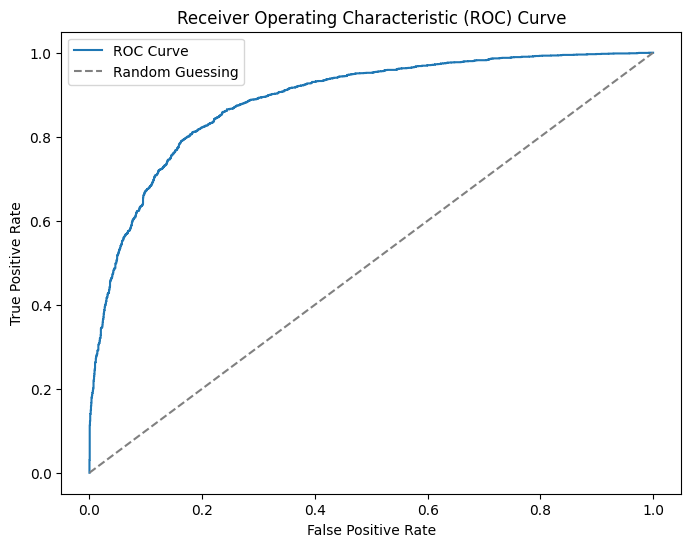

In [14]:
predicted = parent.load_and_predict(name, X_test)
observed = y_test

parent.plot_roc_curve(observed, parent.ravel(predicted))

In [49]:
for metric, value in loss.items():
    print(f"{metric}: {value:.3f}")

accuracy: 0.801
precision: 0.844
recall: 0.746
f1_score: 0.792
auc: 0.887


#### additional testing using the reverse_LaFleur_supp.csv

3048/3048 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


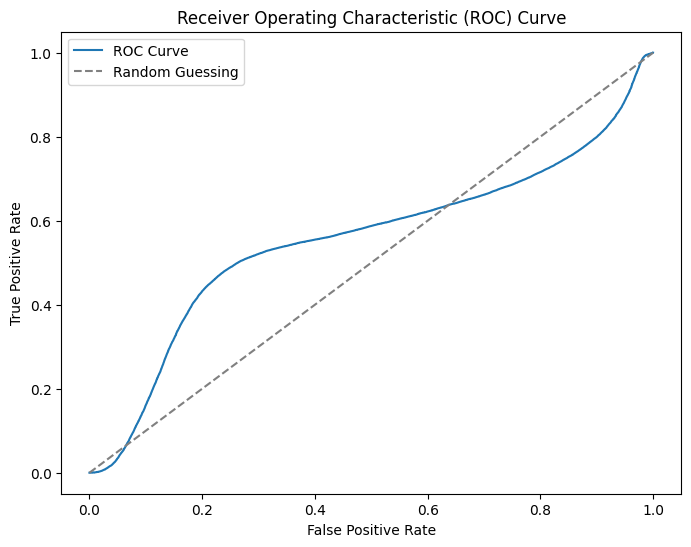

In [30]:
# All sequences in reverse_LaFleur_supp.csv

df_LaFleur = parent.load_and_preprocess_data('../Data/Augmented/reverse_LaFleur_supp.csv')
X_test_LaFleur = df_LaFleur[['Promoter Sequence']].astype(str).agg(''.join, axis=1)
X_test_LaFleur = parent.preprocess_sequences(X_test_LaFleur)
y_test_LaFleur = df_LaFleur['Reversed'].apply(lambda x: 0 if x == True else 1)

predicted_LaFleur = parent.load_and_predict(name, X_test_LaFleur)
parent.plot_roc_curve(y_test_LaFleur, parent.ravel(predicted_LaFleur))

In [48]:
loss_Lafleur = parent.evaluate_model(model, X_test_LaFleur, y_test_LaFleur)
for metric, value in loss_Lafleur.items():
    print(f"{metric}: {value:.3f}")

3048/3048 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
accuracy: 0.616
precision: 0.683
recall: 0.433
f1_score: 0.530
auc: 0.554


In [ ]:
for metric, value in loss_Lafleur.items():
    print(f"{metric}: {value:.3f}")

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = y_test_LaFleur
y_pred = (parent.ravel(predicted_LaFleur) > 0.5).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


True Negatives (TN): 38973
False Positives (FP): 9787
False Negatives (FN): 27632
True Positives (TP): 21135

Classification Report:
              precision    recall  f1-score   support

           0     0.5851    0.7993    0.6756     48760
           1     0.6835    0.4334    0.5304     48767

    accuracy                         0.6163     97527
   macro avg     0.6343    0.6163    0.6030     97527
weighted avg     0.6343    0.6163    0.6030     97527



In [51]:
len(df_LaFleur['File Name'].unique())

9

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
La Fleur et al (Fig 3a).csv
10782


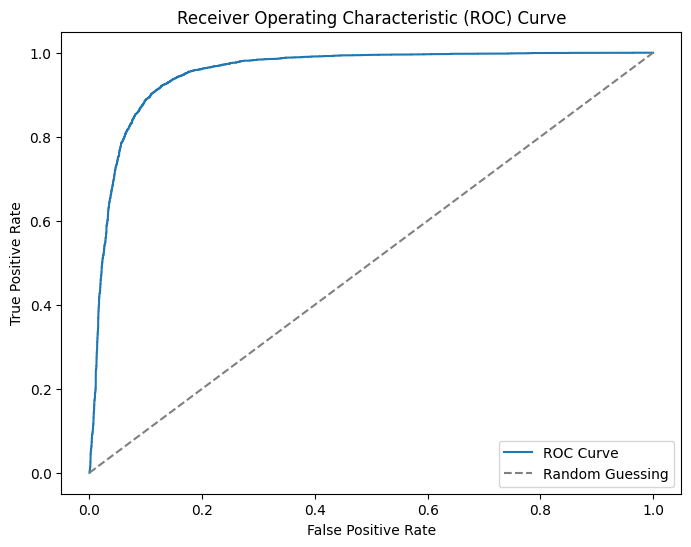

682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Urtecho et al (Fig 3c, S7b).csv
21795


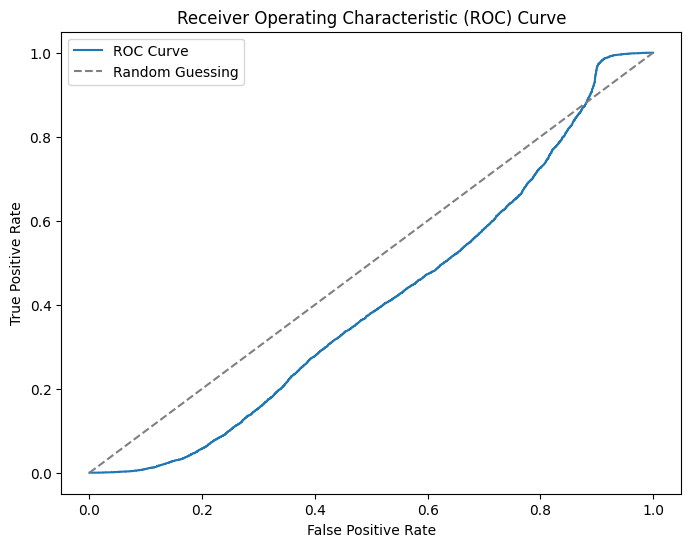

272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Hossain et al (Fig 3d, S7d).csv
8699


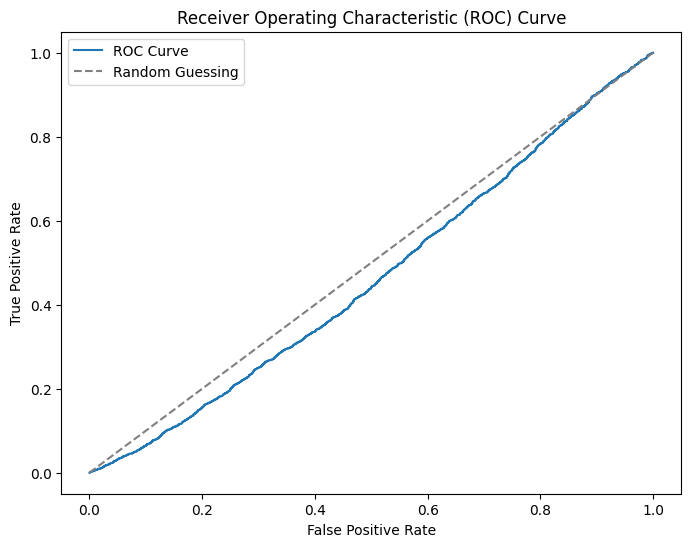

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Yu et al (Fig S3).csv
2985


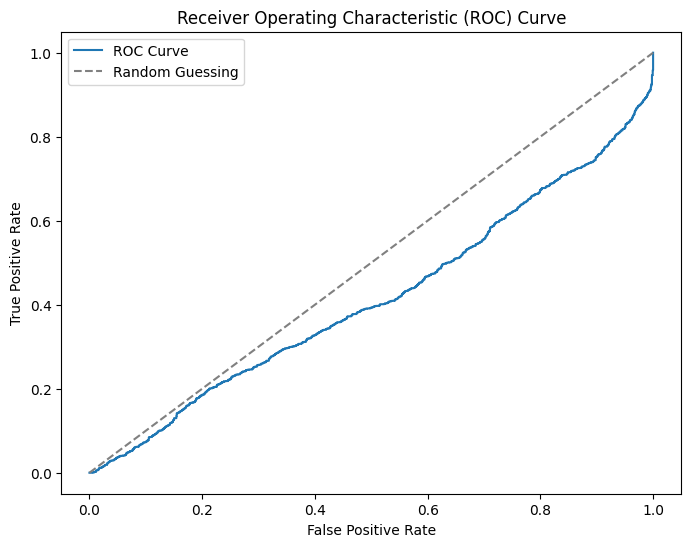

718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Lagator 36N.csv
22969


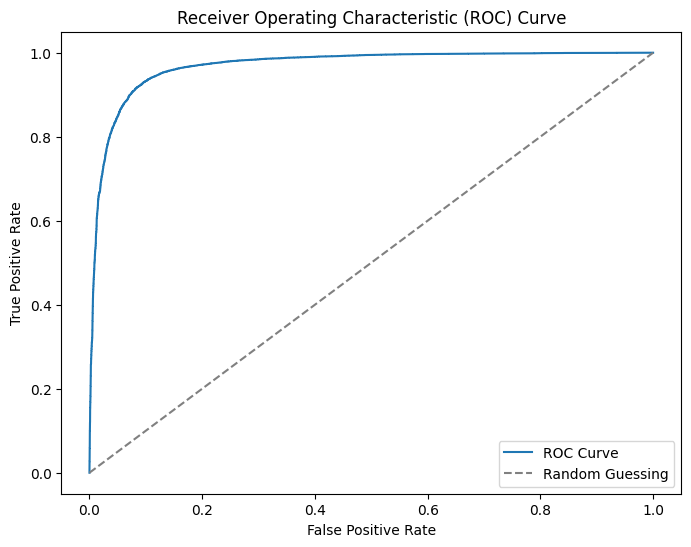

182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Lagator Pl.csv
5805


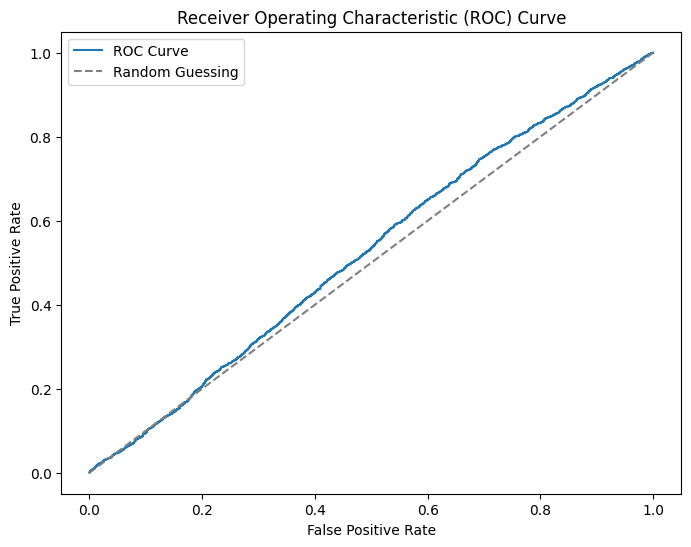

763/763 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Lagator Pr.csv
24387


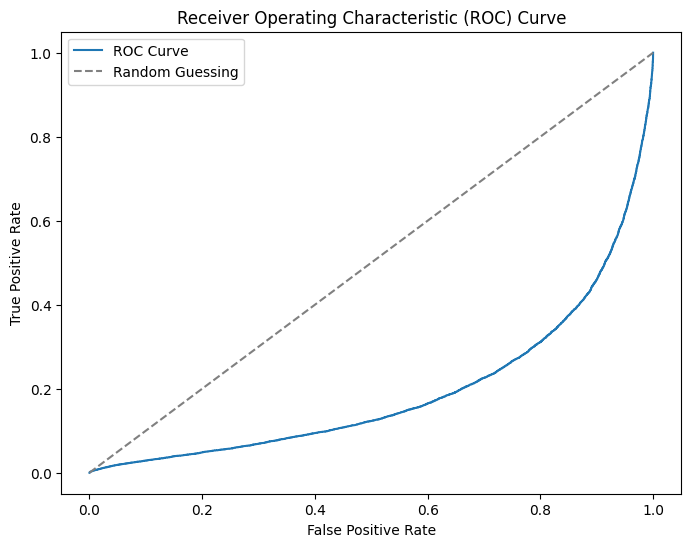

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Anderson Series (Fig 4c).csv
36


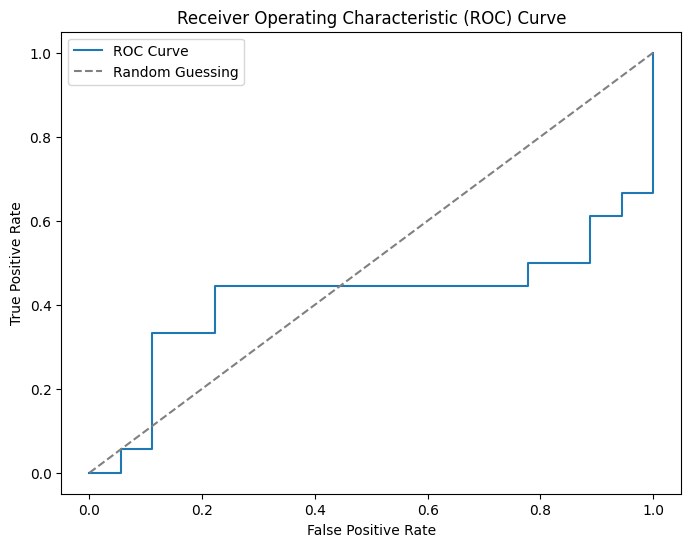

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
De Novo Designs (Fig 5 b and c).csv
69


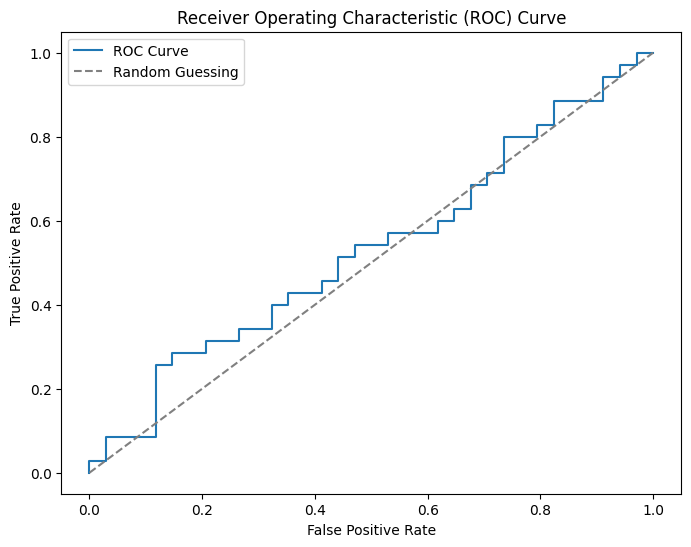

In [53]:
# plot ROC for each file in reverse_LaFleur_supp.csv

for file_name in df_LaFleur['File Name'].unique():
    temp_df = df_LaFleur[df_LaFleur['File Name'] == file_name]
    X_test_temp = temp_df[['Promoter Sequence']].astype(str).agg(''.join, axis=1)
    X_test_temp = parent.preprocess_sequences(X_test_temp)
    y_test_temp = temp_df['Reversed'].apply(lambda x: 0 if x == True else 1)
    predicted_temp = parent.load_and_predict(name, X_test_temp)

    print(file_name)
    print(len(temp_df))
    parent.plot_roc_curve(y_test_temp, parent.ravel(predicted_temp))

In [44]:
len(df_LaFleur[df_LaFleur['File Name'] == 'De Novo Designs (Fig 5 b and c).csv'])

69